# Instance Generator

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping

/home/carmelo/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/carmelo/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/carmelo/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/carmelo/anaconda3/envs/tf-gpu/lib/pyt

In [2]:
# generate the next frame in the sequence

def next_frame(last_row, last_frame, column):
    lower = max(0, last_row-1)
    upper = min(last_frame.shape[0]-1, last_row+1)
    row = np.random.randint(lower, upper+1)
    frame = last_frame.copy()
    frame[row, column] = 1
    return frame, row
    

In [3]:
# generate a sequence of frames of a dot moving across an image

def build_frames(size):
    frames = list()
    
    # create the first frame
    frame = np.zeros((size, size), dtype=np.float32)
    row = np.random.randint(0, size)
    # decide if we are heading left or right
    right = 1 if np.random.rand()<0.5 else 0
    col = 0 if right else size-1
    frame[row, col] = 1
    frames.append(frame)
    # cretae all remaining frames
    for i in range(1, size):
        col = col + 1 if right else col - 1
        frame, row = next_frame(row, frame, col)
        frames.append(frame)
    return frames, right

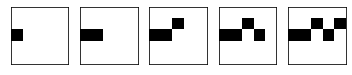

In [4]:
size = 5
frames, right = build_frames(size)

plt.figure()
for i in range(size):
    plt.subplot(1, size, i+1)
    plt.imshow(frames[i], cmap='binary')
    
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
def generate_examples(size, n_patterns):
    X, y = list(), list()
    for _ in range(n_patterns):
        frames, right = build_frames(size)
        X.append(frames)
        y.append(right)
    X = np.array(X).reshape(n_patterns, size, size, size, 1)
    y = np.array(y).reshape(n_patterns, 1)
    return X, y

In [7]:
# [samples, timesteps, width, height, channels]
SIZE = 50
TIMESTEPS, WIDTH, HEIGHT = SIZE, SIZE, SIZE
NPATTERNS = 4096
X_train, y_train = generate_examples(SIZE, NPATTERNS)
X_test, y_test = generate_examples(SIZE, 128)

# TimeDistributed Way 1

In [8]:
def build_cnn(inputs):
    x = Conv2D(2, (2,2), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    return Model(inputs=inputs, outputs=x, name='cnn_model')


inputs = Input(shape=(WIDTH, HEIGHT, 1))
cnn_model = build_cnn(inputs)
cnn_model.summary()

inputs = Input(shape=(TIMESTEPS, WIDTH, HEIGHT, 1))
x = TimeDistributed(cnn_model)(inputs)
x = LSTM(50)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=x, name='lstm_model')
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 49, 49, 2)         10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              

In [9]:
BATCH_SIZE = 32
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=128, validation_split=0.2,
                    callbacks= [ EarlyStopping(monitor='val_loss', patience=16)], verbose=2)

loss, acc =  model.evaluate(X_test, y_test, verbose=0)
print('loss %f, acc %f' % (loss, acc*100.))

Train on 3276 samples, validate on 820 samples
Epoch 1/128
3276/3276 - 11s - loss: 0.2156 - acc: 0.8971 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 2/128
3276/3276 - 9s - loss: 0.0877 - acc: 0.9847 - val_loss: 0.0147 - val_acc: 1.0000
Epoch 3/128
3276/3276 - 9s - loss: 0.0070 - acc: 0.9997 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 4/128
3276/3276 - 9s - loss: 0.0015 - acc: 1.0000 - val_loss: 9.9065e-04 - val_acc: 1.0000
Epoch 5/128
3276/3276 - 9s - loss: 7.3778e-04 - acc: 1.0000 - val_loss: 5.7930e-04 - val_acc: 1.0000
Epoch 6/128
3276/3276 - 9s - loss: 4.6994e-04 - acc: 1.0000 - val_loss: 3.9839e-04 - val_acc: 1.0000
Epoch 7/128
3276/3276 - 9s - loss: 3.3904e-04 - acc: 1.0000 - val_loss: 3.0060e-04 - val_acc: 1.0000
Epoch 8/128
3276/3276 - 9s - loss: 2.6340e-04 - acc: 1.0000 - val_loss: 2.3952e-04 - val_acc: 1.0000
Epoch 9/128
3276/3276 - 9s - loss: 2.1436e-04 - acc: 1.0000 - val_loss: 1.9876e-04 - val_acc: 1.0000
Epoch 10/128
3276/3276 - 9s - loss: 1.8022e-04 - acc: 1.0000 - val_loss

Epoch 82/128
3276/3276 - 9s - loss: 1.8208e-06 - acc: 1.0000 - val_loss: 1.7829e-06 - val_acc: 1.0000
Epoch 83/128
3276/3276 - 9s - loss: 1.7282e-06 - acc: 1.0000 - val_loss: 1.6922e-06 - val_acc: 1.0000
Epoch 84/128
3276/3276 - 9s - loss: 1.6396e-06 - acc: 1.0000 - val_loss: 1.6051e-06 - val_acc: 1.0000
Epoch 85/128
3276/3276 - 9s - loss: 1.5545e-06 - acc: 1.0000 - val_loss: 1.5213e-06 - val_acc: 1.0000
Epoch 86/128
3276/3276 - 9s - loss: 1.4727e-06 - acc: 1.0000 - val_loss: 1.4409e-06 - val_acc: 1.0000
Epoch 87/128
3276/3276 - 9s - loss: 1.3942e-06 - acc: 1.0000 - val_loss: 1.3633e-06 - val_acc: 1.0000
Epoch 88/128
3276/3276 - 9s - loss: 1.3186e-06 - acc: 1.0000 - val_loss: 1.2892e-06 - val_acc: 1.0000
Epoch 89/128
3276/3276 - 9s - loss: 1.2461e-06 - acc: 1.0000 - val_loss: 1.2176e-06 - val_acc: 1.0000
Epoch 90/128
3276/3276 - 9s - loss: 1.1768e-06 - acc: 1.0000 - val_loss: 1.1495e-06 - val_acc: 1.0000
Epoch 91/128
3276/3276 - 9s - loss: 1.1106e-06 - acc: 1.0000 - val_loss: 1.0847e-0

# TimeDistributed Way 2

In [ ]:
cnn_model = Sequential()
cnn_model.add(Input(shape=(WIDTH, HEIGHT, 1)))

cnn_model.add(Conv2D(2, (2,2), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Flatten())

cnn_model.summary()

model = Sequential()
model.add(TimeDistributed(cnn_model, input_shape=(None, WIDTH, HEIGHT, 1)))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


model.summary()

In [ ]:
BATCH_SIZE = 32
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=128, validation_split=0.2,
                    callbacks= [ EarlyStopping(monitor='val_loss', patience=16)], verbose=2)

loss, acc =  model.evaluate(X_test, y_test, verbose=0)
print('loss %f, acc %f' % (loss, acc*100.))

# TimeDistributed Way 3

In [ ]:
# CNN
model = Sequential()
model.add(TimeDistributed(Conv2D(2, (2,2), activation='relu'), input_shape=(None, WIDTH, HEIGHT, 1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


model.summary()

In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=128, validation_split=0.2,
                    callbacks= [ EarlyStopping(monitor='val_loss', patience=16)], verbose=2)

loss, acc =  model.evaluate(X_test, y_test, verbose=0)
print('loss %f, acc %f' % (loss, acc*100.))